# A Prototype For Fitting Monotonic Cubic Splines to a Tdigest Sketch

### Register Custom Maven Resolvers

In [1]:
import Resolvers._
interp.resolvers() = interp.resolvers() :+ Resolver.Http(
  "manyangled",
  "https://dl.bintray.com/manyangled/maven/",
  MavenPattern,
  true
)
interp.resolvers() = interp.resolvers() :+ Resolver.Http(
    "cibotech",
    "https://dl.bintray.com/cibotech/public/",
    MavenPattern,
    true
)

import Resolvers._


### Package imports

In [2]:
// Apache Commons Math
import $ivy.`org.apache.commons:commons-math3:3.6.1`

// T-digest sketching
import $ivy.`org.isarnproject::isarn-sketches:0.1.2`

// Convex Optimization
import $ivy.`com.manyangled:gibbous:0.1.1`

// Monotonic splining
import $ivy.`com.manyangled:snowball:0.1.1`

// EvilPlot plotting routines
import $ivy.`com.cibo::evilplot:0.4.1`
import $ivy.`com.cibo::evilplot-repl:0.4.1`

import $ivy.$                                       

// T-digest sketching

import $ivy.$                                       

// Convex Optimization

import $ivy.$                             

// Monotonic splining

import $ivy.$                              

// EvilPlot plotting routines

import $ivy.$                         

import $ivy.$                              

### Imports for EvilPlot plotting support

In [3]:
import com.cibo.evilplot._
import com.cibo.evilplot.plot._
import com.cibo.evilplot.plot.aesthetics.DefaultTheme._
import com.cibo.evilplot.numeric.Point
import com.cibo.evilplot.colors.HTMLNamedColors
import com.cibo.evilplot.numeric.Bounds
import com.cibo.evilplot.plot.renderers.BarRenderer

import com.cibo.evilplot._

import com.cibo.evilplot.plot._

import com.cibo.evilplot.plot.aesthetics.DefaultTheme._

import com.cibo.evilplot.numeric.Point

import com.cibo.evilplot.colors.HTMLNamedColors

import com.cibo.evilplot.numeric.Bounds

import com.cibo.evilplot.plot.renderers.BarRenderer

#### Import some distributions to generate some sample data

In [4]:
import org.apache.commons.math3.distribution.GammaDistribution
import org.apache.commons.math3.distribution.NormalDistribution

import org.apache.commons.math3.distribution.GammaDistribution

import org.apache.commons.math3.distribution.NormalDistribution

#### Import data sketching and spline interpolation

In [5]:
import org.isarnproject.sketches.TDigest
import com.manyangled.snowball.analysis.interpolation.MonotonicSplineInterpolator

import org.isarnproject.sketches.TDigest

import com.manyangled.snowball.analysis.interpolation.MonotonicSplineInterpolator

#### declare some sampling distributions

In [6]:
val gamma = new GammaDistribution(1.0, 1.0)
val normal = new NormalDistribution()

gamma: GammaDistribution = org.apache.commons.math3.distribution.GammaDistribution@3696a1ff
normal: NormalDistribution = org.apache.commons.math3.distribution.NormalDistribution@e756b46

#### Synthesize some data and sketch it

In [7]:
val rawdata = Array.fill(10000) { normal.sample()}
val sketch = TDigest.sketch(rawdata)

rawdata: Array[Double] = Array(
  -0.980094348807355,
  -0.3483409725949223,
  -0.38902425537766433,
  0.3612679764343467,
  0.4683631311162121,
  -0.5196426575825497,
  0.36314735632018186,
  -0.2783034175616441,
  0.39479092642279173,
  -0.713895472813319,
  0.3527206194433585,
...
sketch: TDigest = TDigest(
  0.5,
  0,
  69,
  Map(
    -3.4546880591981357 -> 1.0,
    -3.412444601076031 -> 1.0,
    -3.310304371950363 -> 1.2496774832760906,
    -3.295781779860321 -> 0.7503225167239094,
    -3.2627132725260686 -> 2.0,
    -3.191232808492891 -> 2.0,
    -3.08801461302159 -> 2.6325766798798895,
...

#### Collect some (x,y) points from the sketched CDF
These are used as input to the spline fitting routines

In [8]:
val ydata = (0.0 until 1.0 by 0.01).toArray :+ 1.0
val xdata = ydata.map { y => sketch.cdfInverse(y) }
val (xmin, xmax) = (sketch.cdfInverse(0), sketch.cdfInverse(1))

ydata: Array[Double] = Array(
  0.0,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.06,
  0.07,
  0.08,
  0.09,
  0.1,
...
xdata: Array[Double] = Array(
  -3.4546880591981357,
  -2.311713108759423,
  -2.063863426136517,
  -1.89586983986022,
  -1.7553145869251285,
  -1.6438084659718288,
  -1.5725682795432572,
  -1.5208869631751896,
  -1.472803861852283,
  -1.360009231604042,
  -1.2736985073091205,
...
xmin: Double = -3.4546880591981357
xmax: Double = 3.8938776181997845

### Set up an interpolator and fit the data from the CDF sketch
Note that the PDF spline is just the gradient of the CDF spline

In [9]:
val interpolator = new MonotonicSplineInterpolator()
interpolator.addEqualityConstraint(xmin, 0.0 + 1e-9)
interpolator.addEqualityConstraint(xmax, 1.0 - 1e-9)
interpolator.setBounds(xmin, xmax)
interpolator.setM(20)

val cdfspline = interpolator.interpolate(xdata, ydata)
val pdfspline = cdfspline.polynomialSplineDerivative()

interpolator: MonotonicSplineInterpolator = com.manyangled.snowball.analysis.interpolation.MonotonicSplineInterpolator@e0f81ee
cdfspline: org.apache.commons.math3.analysis.polynomials.PolynomialSplineFunction = org.apache.commons.math3.analysis.polynomials.PolynomialSplineFunction@950000f
pdfspline: org.apache.commons.math3.analysis.polynomials.PolynomialSplineFunction = org.apache.commons.math3.analysis.polynomials.PolynomialSplineFunction@5c2a68f4

### These wrap the raw splines and define the domain to (-inf, +inf)

In [10]:
val cdffit = (x: Double) => x match {
    case x if (x <= xmin) => 0.0
    case x if (x >= xmax) => 1.0
    case x => cdfspline.value(x)
}
val pdffit = (x: Double) => x match {
    case x if (x <= xmin) => 0.0
    case x if (x >= xmax) => 0.0
    case x => pdfspline.value(x)
}

cdffit: Double => Double = <function1>
pdffit: Double => Double = <function1>

### Declare some custom binning functions for EvilPlot
These should probably become a PR

In [11]:
object customBinners { 
    def cumulative(values: Seq[Double], xbounds: Bounds, binCount: Int): Seq[Point] = 
        doBinning(values, xbounds, binCount, false, true)
    def cumulativeNormalized(values: Seq[Double], xbounds: Bounds, binCount: Int): Seq[Point] = 
        doBinning(values, xbounds, binCount, true, true)
    def density(values: Seq[Double], xbounds: Bounds, binCount: Int): Seq[Point] = {
        val binWidth = xbounds.range / binCount
        doBinning(values, xbounds, binCount, true, false).map { case Point(x,y) => Point(x, y/binWidth) }
    }

    private def doBinning(values: Seq[Double], xbounds: Bounds, binCount: Int,
                              normalize: Boolean, cumulative: Boolean): Seq[Point] = {
        val binWidth = xbounds.range / binCount
        val grouped = values.groupBy { value => 
            math.min(((value - xbounds.min) / binWidth).toInt, binCount - 1)
        }
        val pts = (0 until binCount).flatMap { i =>
            grouped.get(i).map { vs =>
                val y = (if (normalize) vs.size.toDouble / values.size else vs.size)
                val x = i * binWidth + xbounds.min
                Point(x, y)
            }
        }
        if (!cumulative) pts else {
            pts.scanLeft(Point(0,0)) { case (Point(_, t), Point(x,y)) => Point(x, y + t) }.drop(1)
        }
    }
}

defined object customBinners

### Compare a cumulative histogram, the "raw" sketch CDF and a cubic spline
* Green bars are cumulative histogram of data
* Red line is the CDF taken directly from the t-digest sketch
* Blue line is the spline that was fit to the raw CDF data

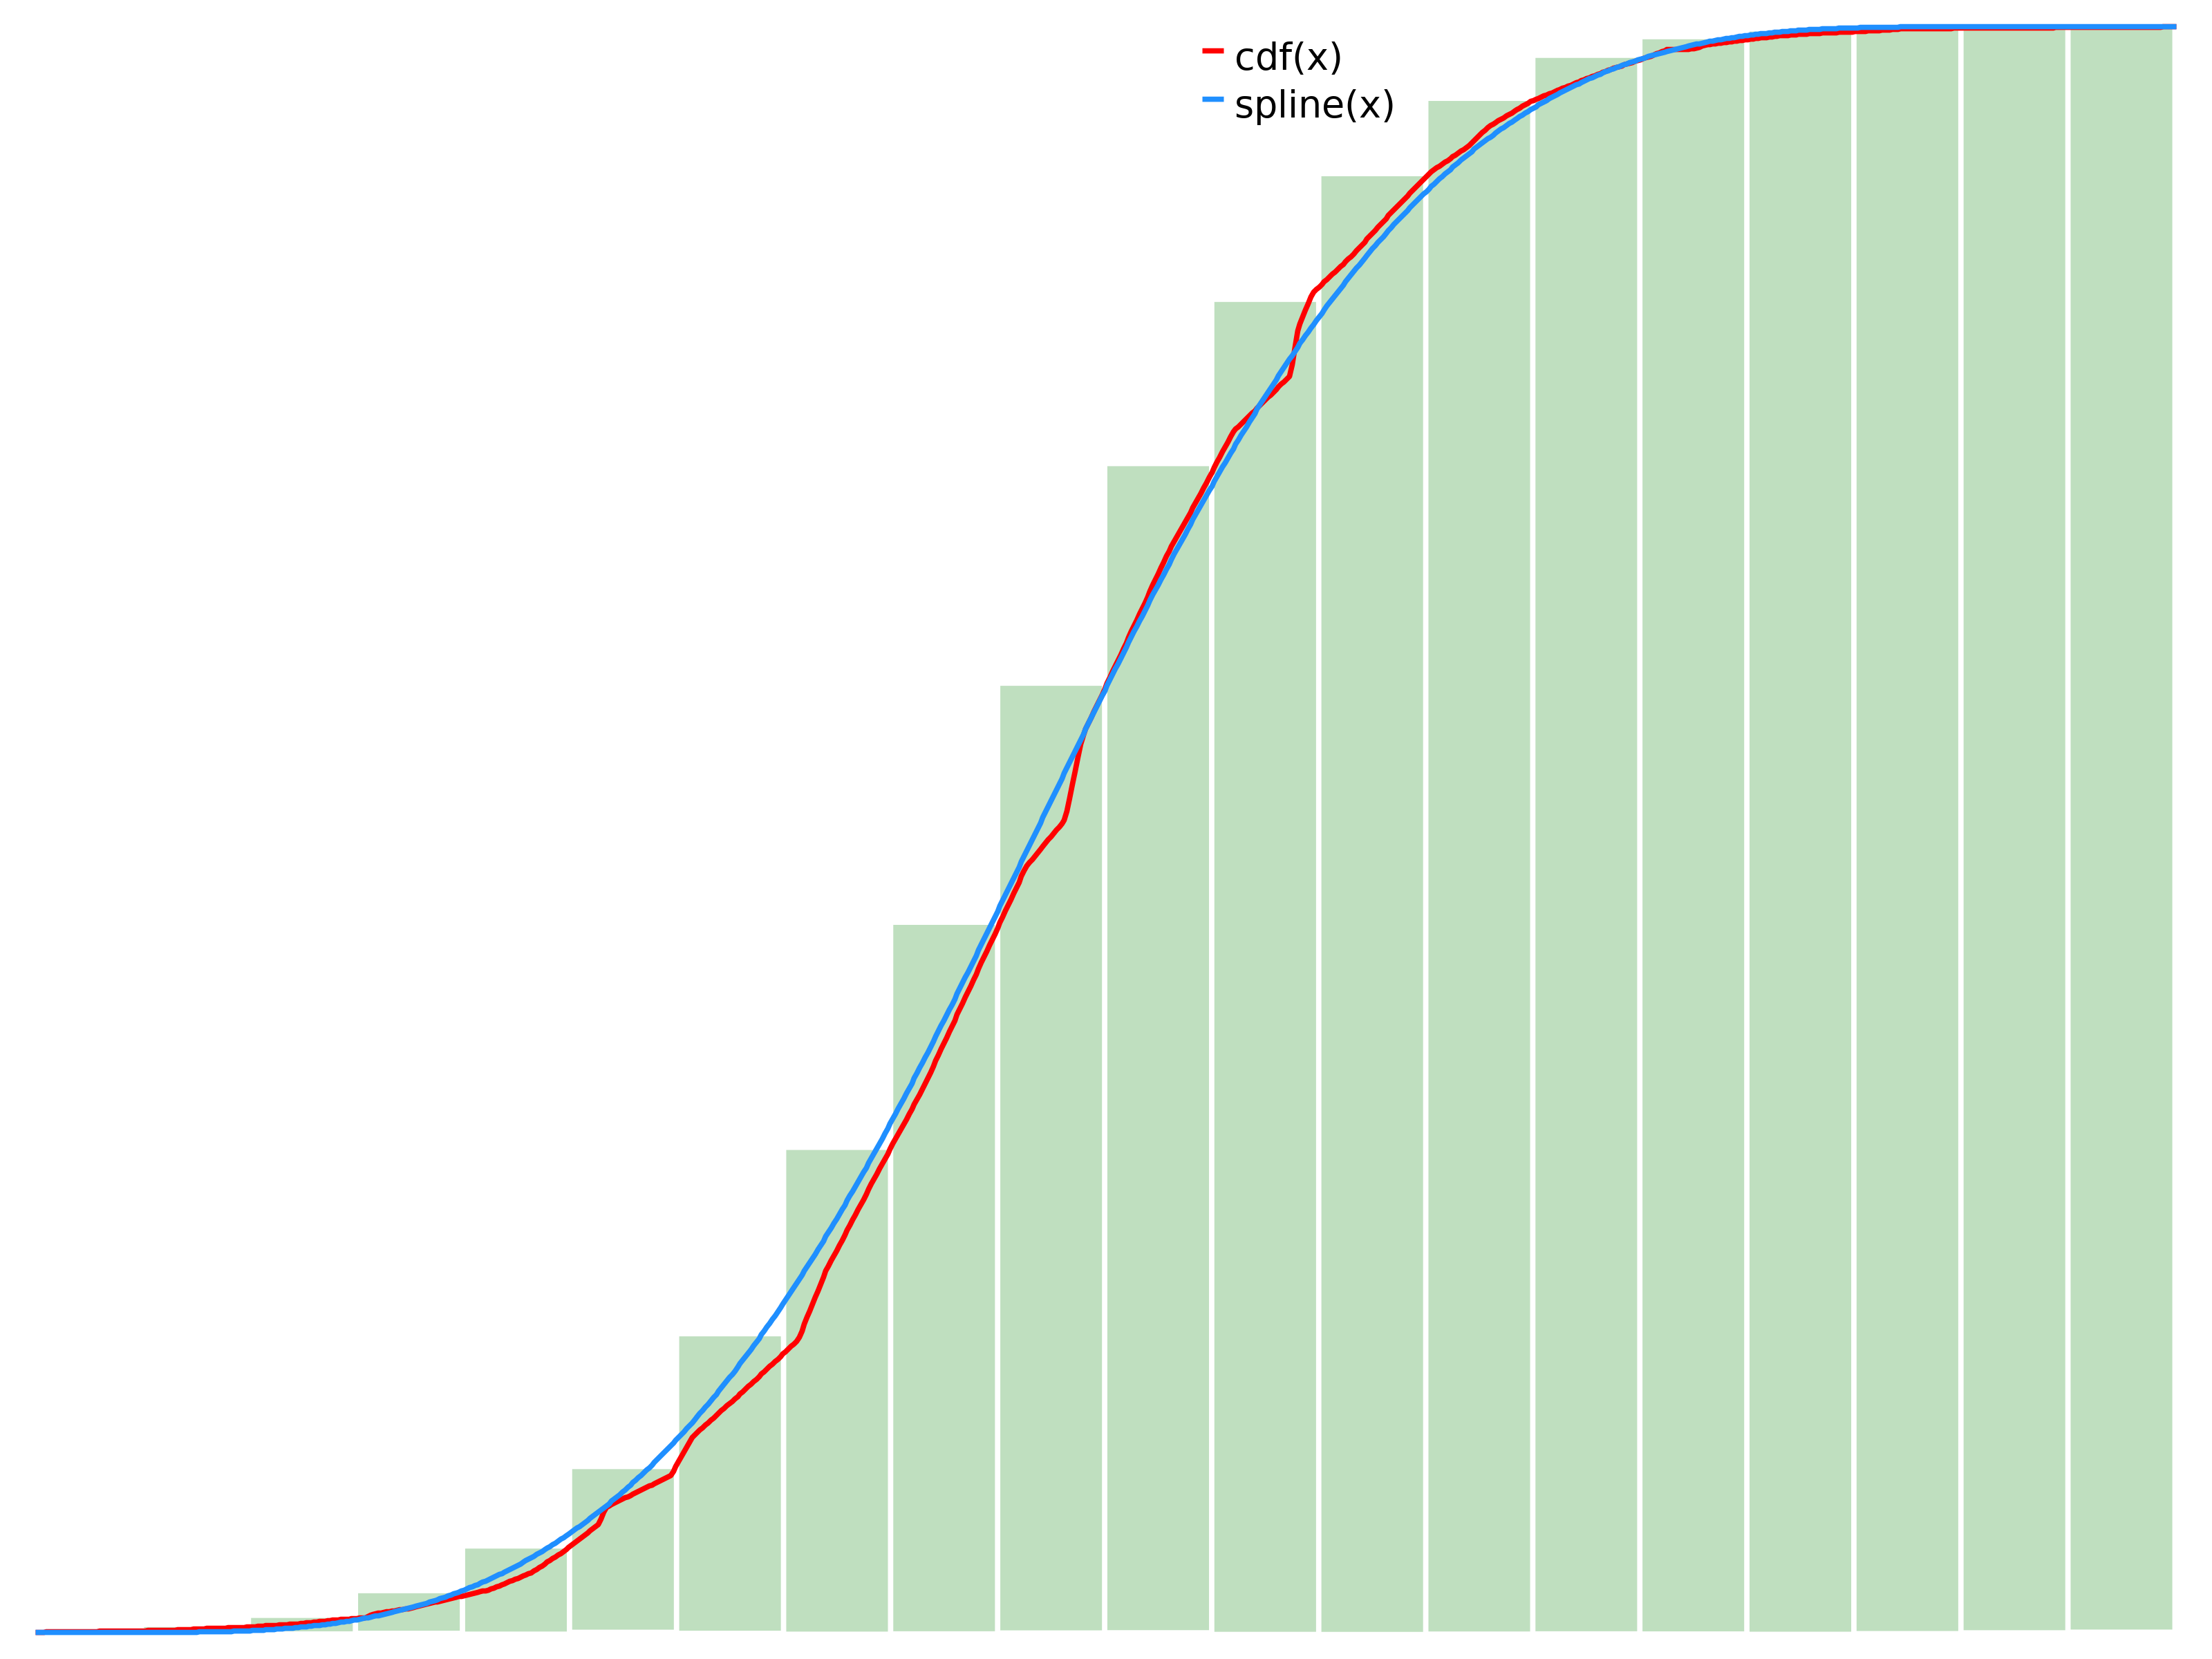

defined function showCumulative

In [12]:
def showCumulative = {
val histplot = Histogram(
    rawdata,
    barRenderer = Some(BarRenderer.default(Some(HTMLNamedColors.green.copy(opacity = 0.25)))),
    binningFunction = customBinners.cumulativeNormalized)
val cdfplot = FunctionPlot.series((x:Double) => sketch.cdf(x), "cdf(x)", HTMLNamedColors.red, xbounds = Some(Bounds(xmin, xmax)))
val splineplot = FunctionPlot.series((x:Double) => cdffit(x), "spline(x)", HTMLNamedColors.dodgerBlue, xbounds = Some(Bounds(xmin, xmax)))
val plt = Overlay(histplot, cdfplot, splineplot).overlayLegend(x=0.6).render()
publish.png(plt.asBufferedImage)
}
showCumulative

### Compare a "density" histogram, the "raw" sketch PDF and a cubic spline of PDF
* Green bars are raw histogram of data
* Red line is the PDF estimated directly from the t-digest sketch
* Blue line is the gradient of the CDF spline above

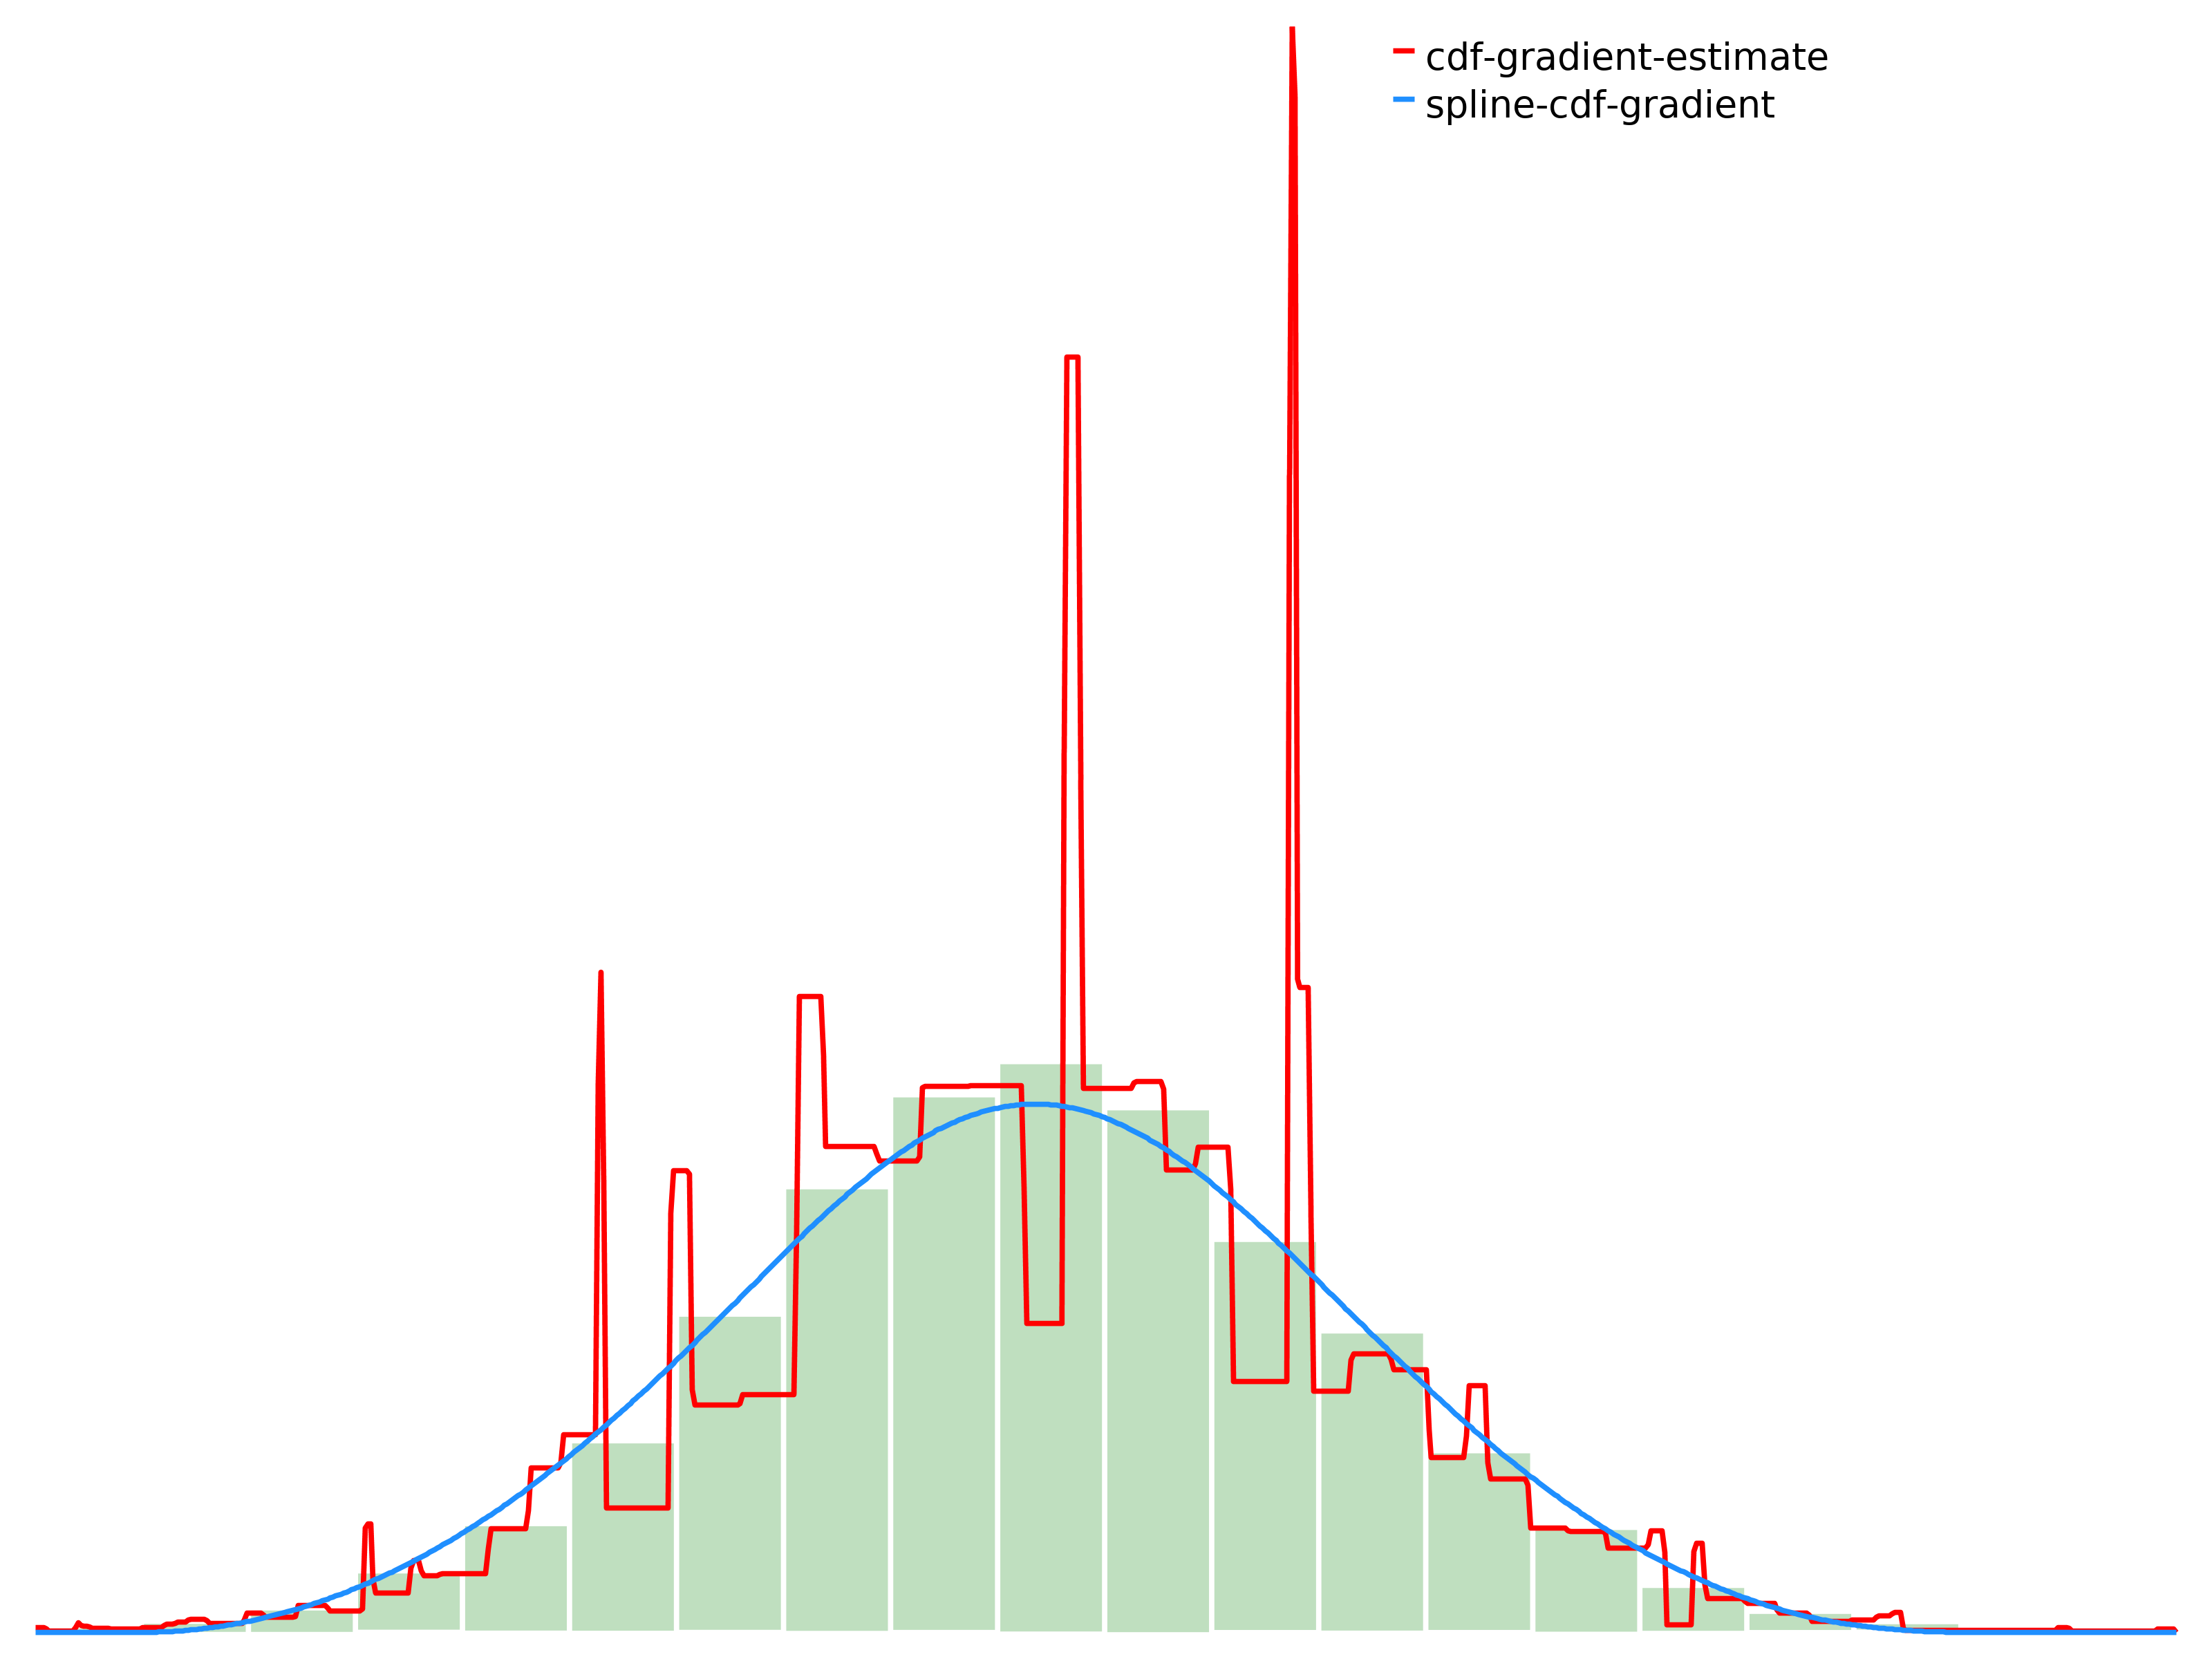

defined function showPDF

In [13]:
def showPDF {
val histplot = Histogram(
    rawdata,
    barRenderer = Some(BarRenderer.default(Some(HTMLNamedColors.green.copy(opacity = 0.25)))),
    binningFunction = customBinners.density)
val cdfplot = FunctionPlot.series((x:Double) => (sketch.cdf(x+0.01) - sketch.cdf(x))/0.01, "cdf-gradient-estimate", HTMLNamedColors.red, xbounds = Some(Bounds(xmin, xmax)))
val splineplot = FunctionPlot.series((x:Double) => pdffit(x), "spline-cdf-gradient", HTMLNamedColors.dodgerBlue, xbounds = Some(Bounds(xmin, xmax)))
val plt = Overlay(histplot, cdfplot, splineplot).overlayLegend(x=0.8).render()
publish.png(plt.asBufferedImage)
}
showPDF